In [49]:
import csv
import numpy
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pandas as pd
from matplotlib.ticker import MultipleLocator

plt.rcParams.update({'font.size': 18})

In [50]:
filename = '/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/all_exp_rel_wmean_replicated_msd_50um_area_roughness_gld_thickness_huang_cell_shape_volume_sa.csv'

df = pd.read_csv(filename)

print(df.columns)
# labels = ['area', 'roughness', 'growth_layer_depth']#, 'major', 'minor', 'ar', 'volume', 'sa']
labels = ['area', 'roughness', 'growth_layer_depth', 'thickness', 'major', 'minor', 'ar', 'volume', 'sa']
# labels = ['major', 'minor', 'ar', 'volume', 'sa']
labels_err = ['area_ste', 'roughness_ste', 'growth_layer_depth_ste', 'thickness_ste', 'std_major', 'std_minor']

data_df = df[labels]
data_err_df = df[labels_err]

data_err_df['ar_err'] = numpy.nan
data_err_df['volume_err'] = numpy.nan
data_err_df['sa_err'] = numpy.nan

data = data_df.values.astype('float')
data_err = data_err_df.values.astype('float')

target = df['wmean'].values.astype('float')
target_err = df['wmean_ste'].values.astype('float')

experiment = df['experiment']
position = df['position']

Index(['experiment', 'position', 'genotype', 'position in KQY plates', 'wmean',
       'wmean_ste', 'n', 'area', 'area_ste', 'roughness', 'roughness_ste',
       'growth_layer_depth', 'growth_layer_depth_ste', 'thickness',
       'thickness_ste', 'phenotype_n', 'major', 'minor', 'ar', 'std_major',
       'std_minor', 'volume', 'sa'],
      dtype='object')


/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/qinqinyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [51]:
# Only looking at DE strains

data = data[[i for i in range(len(experiment)) if experiment[i][0:2] == 'DE' and position[i]!='WT']]
data_err = data_err[[i for i in range(len(experiment)) if experiment[i][0:2] == 'DE' and position[i]!='WT']]
target = target[[i for i in range(len(experiment)) if experiment[i][0:2] == 'DE' and position[i]!='WT']]
target_err = target_err[[i for i in range(len(experiment)) if experiment[i][0:2] == 'DE' and position[i]!='WT']]


# Only looking at mreB strains

# data = data[[i for i in range(len(experiment)) if experiment[i] == 'mreB']]
# target = target[[i for i in range(len(experiment)) if experiment[i] == 'mreB']]

# print(data)

<ErrorbarContainer object of 3 artists>

(480, 9)


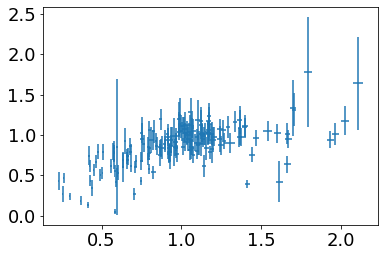

In [52]:
# remove rows with nan values
data_isnan = numpy.isnan(data)
print(data_isnan.shape)
data_entry_isnan = data_isnan.any(axis = 1)

target_isnan = numpy.isnan(target)
joint = ~numpy.logical_or(data_entry_isnan, target_isnan)
joint_ind = numpy.where(joint)[0]

#print(joint_ind)
data_nonan = data[joint_ind,:]
data_err_nonan = data_err[joint_ind,:]
target_nonan = target[joint_ind]
target_err_nonan = target_err[joint_ind]

#print(data_nonan.shape)
#print(target_nonan.shape)

plt.errorbar(data_nonan[:,1], target_nonan, target_err_nonan, data_err_nonan[:,1], linestyle = '')

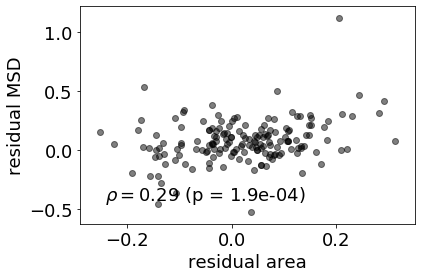

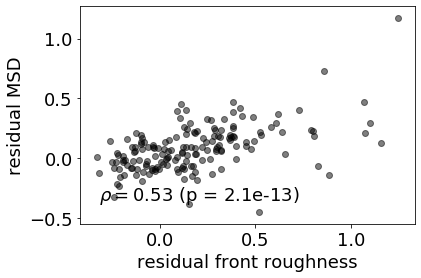

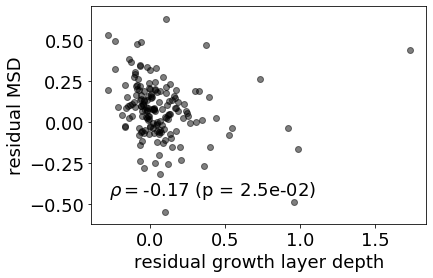

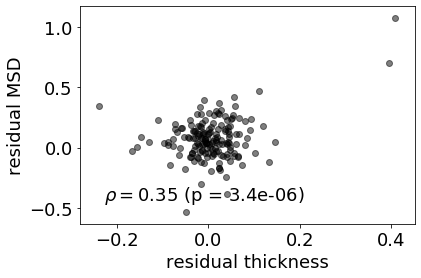

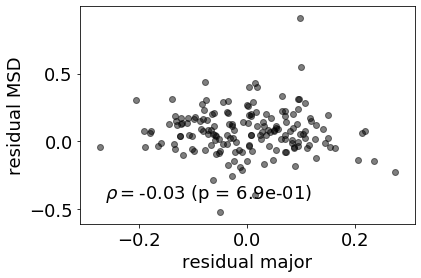

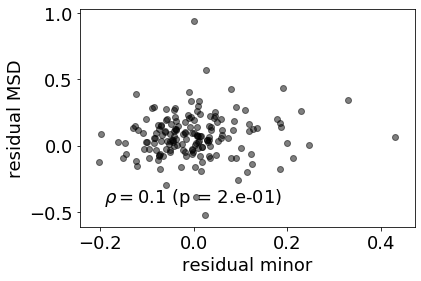

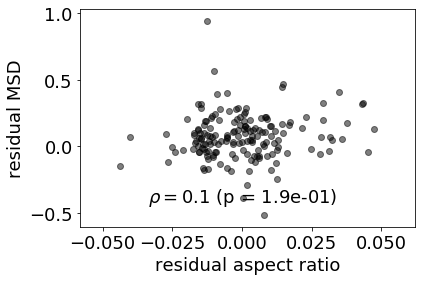

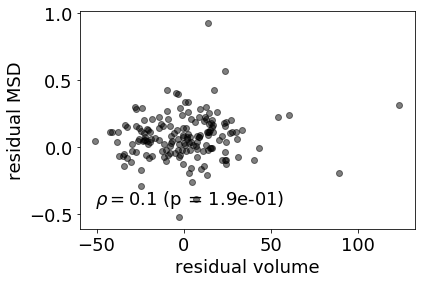

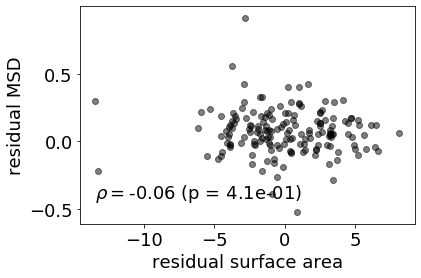

In [77]:
labels_plot = ['area', 'front roughness', 'growth layer depth', 'thickness', 'major', 'minor', 'aspect ratio', 'volume', 'surface area']

# First do linear least squares regression
xi_all = numpy.array(range(len(labels)))
zi_all = numpy.array(range(len(labels)))

for xi in xi_all:
    zi = numpy.delete(zi_all, xi)

    x = data_nonan[:,xi].reshape(-1,1)
    xerr = data_err_nonan[:,xi]

    y = target_nonan.reshape(-1,1)
    yerr = target_err_nonan

    z = data_nonan[:,zi]

    if numpy.isnan(xerr[0]):
        regx = LinearRegression().fit(z, x)
    else:
        regx = LinearRegression().fit(z, x, sample_weight = 1/xerr**2)
    regy = LinearRegression().fit(z, y, sample_weight = 1/yerr**2)

    resx = x.flatten() - (numpy.sum(regx.coef_*z, axis = 1) + regx.intercept_)
    resy = y.flatten() - (numpy.sum(regy.coef_*z, axis = 1) + regy.intercept_)
    (rho, p) = pearsonr(resx,resy)

    plt.scatter(resx, resy, color = 'k', alpha = 0.5)

    plt.text(min(resx)+0.01, min(resy) + 0.1, '$\\rho = $' + str(round(rho,2)) + ' (p = ' + str(numpy.format_float_scientific(p, precision = 1)) + ')')
    plt.xlabel('residual ' + labels_plot[xi])
    plt.ylabel('residual MSD')
    plt.savefig('/Users/qinqinyu/Documents/hallatschek_lab/data_changed/20200228_spatial_genetic_drift_summary/figures/' + labels[xi] + '_msd_de_partial_corr.pdf')
    plt.show()
    # LinearRegression().fit()

In [39]:
print(numpy.transpose(regx.coef_).shape)
print(z.shape)
print(numpy.sum(numpy.transpose(regx.coef_)*z, axis = 1).shape)

(1, 2)
(166, 2)
(166,)
